<a href="https://colab.research.google.com/github/aromaldev/OCR-Malayalam/blob/master/ResNet_for_122_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RESNET

Kaiming He and Xiangyu Zhang and Shaoqing Ren and Jian Sun "Deep Residual Learning for Image Recognition", 2015


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Thu Jun 24 01:17:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import random

#### Dataset Generators

In [ ]:
base_dir = 'dataset'
img_height = 64
img_width = 64
dim = 1
num_epochs=20
batch_size = 64
shape=(img_height,img_width)
input_shape=(img_height,img_width,dim)
num_of_classes=122
img_per_class =2000

In [ ]:
! tar -x -f /content/drive/MyDrive/data/all.tar

In [ ]:
!mv augmented+original\ scanned dataset
!rm -r dataset/100
! rm -r dataset/76

In [ ]:
train_generator = image_dataset_from_directory(
    './dataset',
    image_size=shape,
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode='categorical',
    shuffle=True,
    subset='training',
    seed=123,
    validation_split=0.2
)

val_generator = image_dataset_from_directory(
    './dataset',
    image_size=shape,
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode='categorical',
    shuffle=True,
    subset='validation',
    seed=123,
    validation_split=0.2
)

Found 502228 files belonging to 122 classes.
Using 401783 files for training.
Found 502228 files belonging to 122 classes.
Using 100445 files for validation.


In [ ]:
t = [x for x in val_generator.take(1).as_numpy_iterator()]
print(t[0][1])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
file_list = []

for directory,sub_dir,file_names in os.walk(base_dir):
    if sub_dir != []:
        class_names = sub_dir
    i=0
    for file in file_names:
        if (file.endswith('.jpg') or file.endswith('.JPG')):
            file_list.append(os.path.join(directory,file))
            i+=1
    if i!=0:
        #print(f"{i} Images from : {directory}")
        pass


random.Random(58).shuffle(file_list)

class_names.sort()
image_count =len(file_list)

print(f'Number of images : {image_count}')
assert len(class_names) == num_of_classes
print(f'Image Per class : {len(file_list)/num_of_classes}')
dataset = tf.data.Dataset.from_tensor_slices(file_list)


Number of images : 502228
Image Per class : 4116.622950819672


In [ ]:
print(class_names)

['1', '10', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


In [ ]:
def get_label (file_name):
    parts = tf.strings.split(file_name,os.path.sep)
    one_hot = parts[-2] == class_names
    return one_hot

def decode_image(img_file,image_type=None,resize_shape=None, channels=0):
    #img_file = tf.io.read_file(img_file)
    if image_type == 'jpeg' or image_type == 'jpg':
        img_decoded = tf.image.decode_jpeg(img_file,channels=channels)
    elif image_type == 'png':
        img_decoded = tf.image.decode_png(img_file,channels=channels)
    else:
        img_decoded = tf.image.decode_image(img_file,channels=channels)
    
    if (image_type in ['jpeg','jpg', 'png']) and resize_shape != None:
        img_decoded = tf.image.resize(img_decoded,resize_shape,method='lanczos3')
    #img_decoded = tf.image.rgb_to_grayscale(img_decoded)
    #img_decoded = tf.cast(img_decoded,dtype=tf.float32)
    #img_decoded = tf.math.l2_normalize(img_decoded)
    return img_decoded

def process_path(file_name):
    label = get_label(file_name)
    
    #Load the raw data
    img = tf.io.read_file(file_name)
    img = decode_image(img,'jpeg',resize_shape=shape,channels=dim)
    
    return img,label

In [ ]:
AUTO = tf.data.AUTOTUNE
dataset_img = dataset.map(process_path,num_parallel_calls=AUTO)

val_size = int(image_count * 0.2)
train_ds_img = dataset_img.skip(val_size)
test_ds_img  = dataset_img.take(val_size)

print(f"Number of Training images: {tf.data.experimental.cardinality(train_ds_img).numpy()}")
print(f"Number of Validataion images: {tf.data.experimental.cardinality(test_ds_img).numpy()}")

print(f"Batch size = {batch_size}")
train_batchs = train_ds_img.batch(batch_size)
test_batchs = test_ds_img.batch(batch_size)
print (f"Number of Training batchs: {tf.data.experimental.cardinality(train_batchs).numpy()}")
print (f"Number of Testing batchs: {tf.data.experimental.cardinality(test_batchs).numpy()}")

Number of Training images: 401783
Number of Validataion images: 100445
Batch size = 64
Number of Training batchs: 6278
Number of Testing batchs: 1570


#### Model Architecture

In [ ]:
model = tf.keras.applications.ResNet50V2(
    include_top=True, weights=None, input_tensor=None,
    input_shape=input_shape, pooling=None, classes=122,
    classifier_activation='softmax'
)

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=["accuracy"],
)

model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

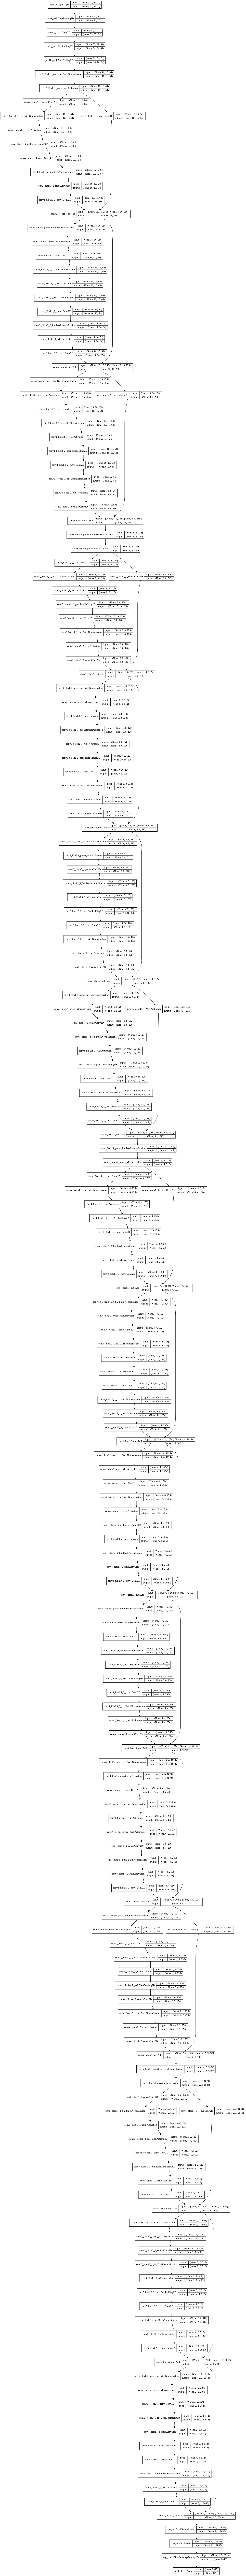

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

#### Model Training

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

checkpoint_filepath = '/content/drive/MyDrive/data/checkpoint_resmodel20'
chk = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(
    train_batchs,
    epochs=num_epochs,
    validation_data=test_batchs,
    callbacks=[es,chk],
    batch_size=batch_size
)

model.save('/content/drive/MyDrive/data/resmodel20.h5')

Epoch 1/20
6278/6278 [==============================] - 380s 54ms/step - loss: 0.4384 - accuracy: 0.8793 - val_loss: 7.2593 - val_accuracy: 0.2248
Epoch 2/20
6278/6278 [==============================] - 344s 52ms/step - loss: 0.1321 - accuracy: 0.9628 - val_loss: 9.2206 - val_accuracy: 0.1577
Epoch 3/20
6278/6278 [==============================] - 355s 54ms/step - loss: 0.0870 - accuracy: 0.9752 - val_loss: 0.2703 - val_accuracy: 0.9210
Epoch 4/20
6278/6278 [==============================] - 342s 52ms/step - loss: 0.0658 - accuracy: 0.9811 - val_loss: 4.7079 - val_accuracy: 0.4566
Epoch 5/20
6278/6278 [==============================] - 342s 52ms/step - loss: 0.0511 - accuracy: 0.9852 - val_loss: 0.0741 - val_accuracy: 0.9790
Epoch 6/20
6278/6278 [==============================] - 345s 52ms/step - loss: 0.0421 - accuracy: 0.9877 - val_loss: 0.0809 - val_accuracy: 0.9782
Epoch 7/20
6278/6278 [==============================] - 349s 53ms/step - loss: 0.0361 - accuracy: 0.9890 - val_loss: 0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


1570/1570 - 42s - loss: 0.0545 - accuracy: 0.9869


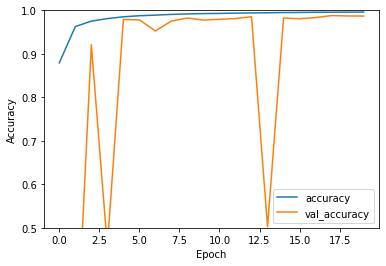

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_batchs, verbose=2)


In [ ]:
model.save('/content/drive/MyDrive/data/resmodel20.h5')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/data/resmodel20.h5')

#### Getting Class Names


In [ ]:
#@title Get the charecter encoding TL;DR


mal_unicode_dict = {
    1:  ("05",),
    2:  ("16",),
    3:  ("2e","4d","2e"),
    4:  ("2e","4d","32"),
    5:  ("2f","4d","2f"),
    6:  ("32","4d","32"),
    7:  ("35","4d","35"),
    8:  ("36","4d","36"),
    9:  ("36","4d","32"),
    10: ("36","4d","1a"),
    11: ("37","4d","1f"),
    12: ("38","4d","32"),
    13: ("17",),
    14: ("38","4d","38"),
    15: ("38","4d","31","4d","31"),
    16: ("38","4d","27"),
    17: ("38","4d","25"),
    18: ("39","4d","2e"),
    19: ("39","4d","28"),
    20: ("39","4d","32"),
    21: ("33","4d","33"),
    22: ("31","4d","31"),
    23: ("7b",),
    24: ("18",),
    25: ("7d",),
    26: ("7c",),
    27: ("7e",),
    28: ("7a",),
    29: ("28","4d","27"),
    30: ("19",),
    31: ("1a",),
    32: ("1b",),
    33: ("1c",),
    34: ("1d",),
    35: ("1e",),
    36: ("1f",),
    37: ("06",),
    38: ("20",),
    39: ("21",),
    40: ("22",),
    41: ("23",),
    42: ("24",),
    43: ("25",),
    44: ("26",),
    45: ("27",),
    46: ("28",),
    47: ("2a",),
    48: ("07",),
    49: ("2b",),
    50: ("2c",),
    51: ("2d",),
    52: ("2e",),
    53: ("2f",),
    54: ("30",),
    55: ("32",),
    56: ("35",),
    57: ("36",),
    58: ("37",),
    59: ("09",),
    60: ("38",),
    61: ("39",),
    62: ("33",),
    63: ("34",),
    64: ("31",),
    65: ("3e",),
    66: ("3f",),
    67: ("40",),
    68: ("41",),
    69: ("42",),
    70: ("0b",),
    71: ("43",),
    72: ("46",),
    73: ("47",),
    74: ("57",),
    75: ("4d",),
    76: ("4d","2f"),
    77: ("4d","30"),
    78: ("4d","35"),
    79: ("15","4d","15"),
    80: ("15","4d","32"),
    81: ("0e",),
    82: ("15","4d","37"),
    83: ("15","4d","24"),
    84: ("17","4d","17"),
    85: ("17","4d","32"),
    86: ("17","4d","28"),
    87: ("17","4d","2e"),
    88: ("19","4d","15"),
    89: ("19","4d","19"),
    90: ("1a","4d","1a"),
    91: ("1a","4d","1b"),
    92: ("0f",),
    93: ("1c","4d","1c"),
    94: ("1e","4d","1a"),
    95: ("1c","4d","1e"),
    96: ("1e","4d","1e"),
    97: ("1f","4d","1f"),
    98: ("21","4d","21"),
    99: ("23","4d","1f"),
    100:("23","4d","21"),
    101:("23","4d","2e"),
    102:("23","4d","23"),
    103:("12",),
    104:("24","4d","24"),
    105:("24","4d","25"),
    106:("24","4d","2d"),
    107:("24","4d","38"),
    108:("24","4d","2e"),
    109:("26","4d","26"),
    110:("26","4d","27"),
    111:("7b","4d","31"),
    112:("28","4d","24"),
    113:("28","4d","26"),
    114:("15",),
    115:("28","4d","28"),
    116:("28","4d","2e"),
    117:("28","4d","25"),
    118:("2a","4d","2a"),
    119:("2a","4d","32"),
    120:("2c","4d","2c"),
    121:("2c","4d","32"),
    122:("2c","4d","27"),
    123:("2c","4d","26"),
    124:("2e","4d","2a")
}

def get_char_encodings(mal_dict = mal_unicode_dict):
    prefix = "0x0d"
    mal_char_dict = {}
    for x in mal_dict.keys():
        char_tuple = mal_dict[x]
        char = [prefix + a for a in char_tuple]
        chr_str = ''.join([chr(int(a,16)) for a in char])   
        #print(f"{x:03} : {chr_str:6}{str(char)}")
        
        mal_char_dict[str(x)] = chr_str#.encode('utf-8')
    return mal_char_dict


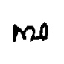

In [ ]:
img = tf.keras.preprocessing.image.load_img('/content/dataset/117/102.jpg'
    , color_mode='grayscale', target_size=shape,interpolation='nearest')

h = []
array = tf.keras.preprocessing.image.img_to_array(img)
h.append(array)
h = np.array(h)

img

In [ ]:
get_char_encodings()[class_names[model.predict(h).argmax()]]

'ന്ഥ'

#### Testing

In [ ]:
import cv2
from pathlib import Path
from sklearn.utils import Bunch
import numpy as np

def load_images(container_path, dimension=(64, 64)): 
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]
    descr = "Malayalam Character classification dataset"
    images = []
    flat_data = []
    target = []
    Sreq = dimension[0]
    for i, direc in enumerate(folders):
        j = 0
        for image_path in direc.iterdir():
            img = tf.keras.preprocessing.image.load_img(str(image_path),color_mode='grayscale', target_size=shape,interpolation='nearest')
            image = tf.keras.preprocessing.image.img_to_array(img)
            images.append(image)
            target.append(i)
            j += 1
            if j == 500:
              break
        print(f'Folder {i+1} of {len(folders)} Retreived')
    flat_data = np.array(flat_data)
    target = np.array(target)
    images = np.array(images)

    return Bunch(data=images,
                 target=target,
                 target_names=categories,
                 DESCR=descr)
    
dataset = load_images('dataset')

Folder 1 of 122 Retreived
Folder 2 of 122 Retreived
Folder 3 of 122 Retreived
Folder 4 of 122 Retreived
Folder 5 of 122 Retreived
Folder 6 of 122 Retreived
Folder 7 of 122 Retreived
Folder 8 of 122 Retreived
Folder 9 of 122 Retreived
Folder 10 of 122 Retreived
Folder 11 of 122 Retreived
Folder 12 of 122 Retreived
Folder 13 of 122 Retreived
Folder 14 of 122 Retreived
Folder 15 of 122 Retreived
Folder 16 of 122 Retreived
Folder 17 of 122 Retreived
Folder 18 of 122 Retreived
Folder 19 of 122 Retreived
Folder 20 of 122 Retreived
Folder 21 of 122 Retreived
Folder 22 of 122 Retreived
Folder 23 of 122 Retreived
Folder 24 of 122 Retreived
Folder 25 of 122 Retreived
Folder 26 of 122 Retreived
Folder 27 of 122 Retreived
Folder 28 of 122 Retreived
Folder 29 of 122 Retreived
Folder 30 of 122 Retreived
Folder 31 of 122 Retreived
Folder 32 of 122 Retreived
Folder 33 of 122 Retreived
Folder 34 of 122 Retreived
Folder 35 of 122 Retreived
Folder 36 of 122 Retreived
Folder 37 of 122 Retreived
Folder 38 

In [ ]:
y_pred = model.predict(dataset.data)
y_pred = np.argmax(y_pred,axis=-1)

In [ ]:
y_index = [class_names[i] for i in y_pred]
y_true = [dataset.target_names[i] for i in dataset.target]

##### Classification Report

In [ ]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay, confusion_matrix
print(classification_report(y_true,y_index))

              precision    recall  f1-score   support

           1       0.99      0.98      0.98       500
          10       0.99      1.00      0.99       500
         101       0.99      0.99      0.99       500
         102       0.99      1.00      0.99       500
         103       0.99      1.00      1.00       500
         104       0.98      0.99      0.99       500
         105       0.99      0.97      0.98       500
         106       1.00      0.99      0.99       500
         107       0.98      0.97      0.98       500
         108       0.98      0.96      0.97       500
         109       1.00      0.98      0.99       500
          11       1.00      0.97      0.99       500
         110       0.99      0.98      0.98       500
         111       0.99      0.98      0.99       500
         112       1.00      1.00      1.00       500
         113       1.00      0.97      0.98       500
         114       0.99      1.00      0.99       500
         115       0.99    

##### Confusion Matrix

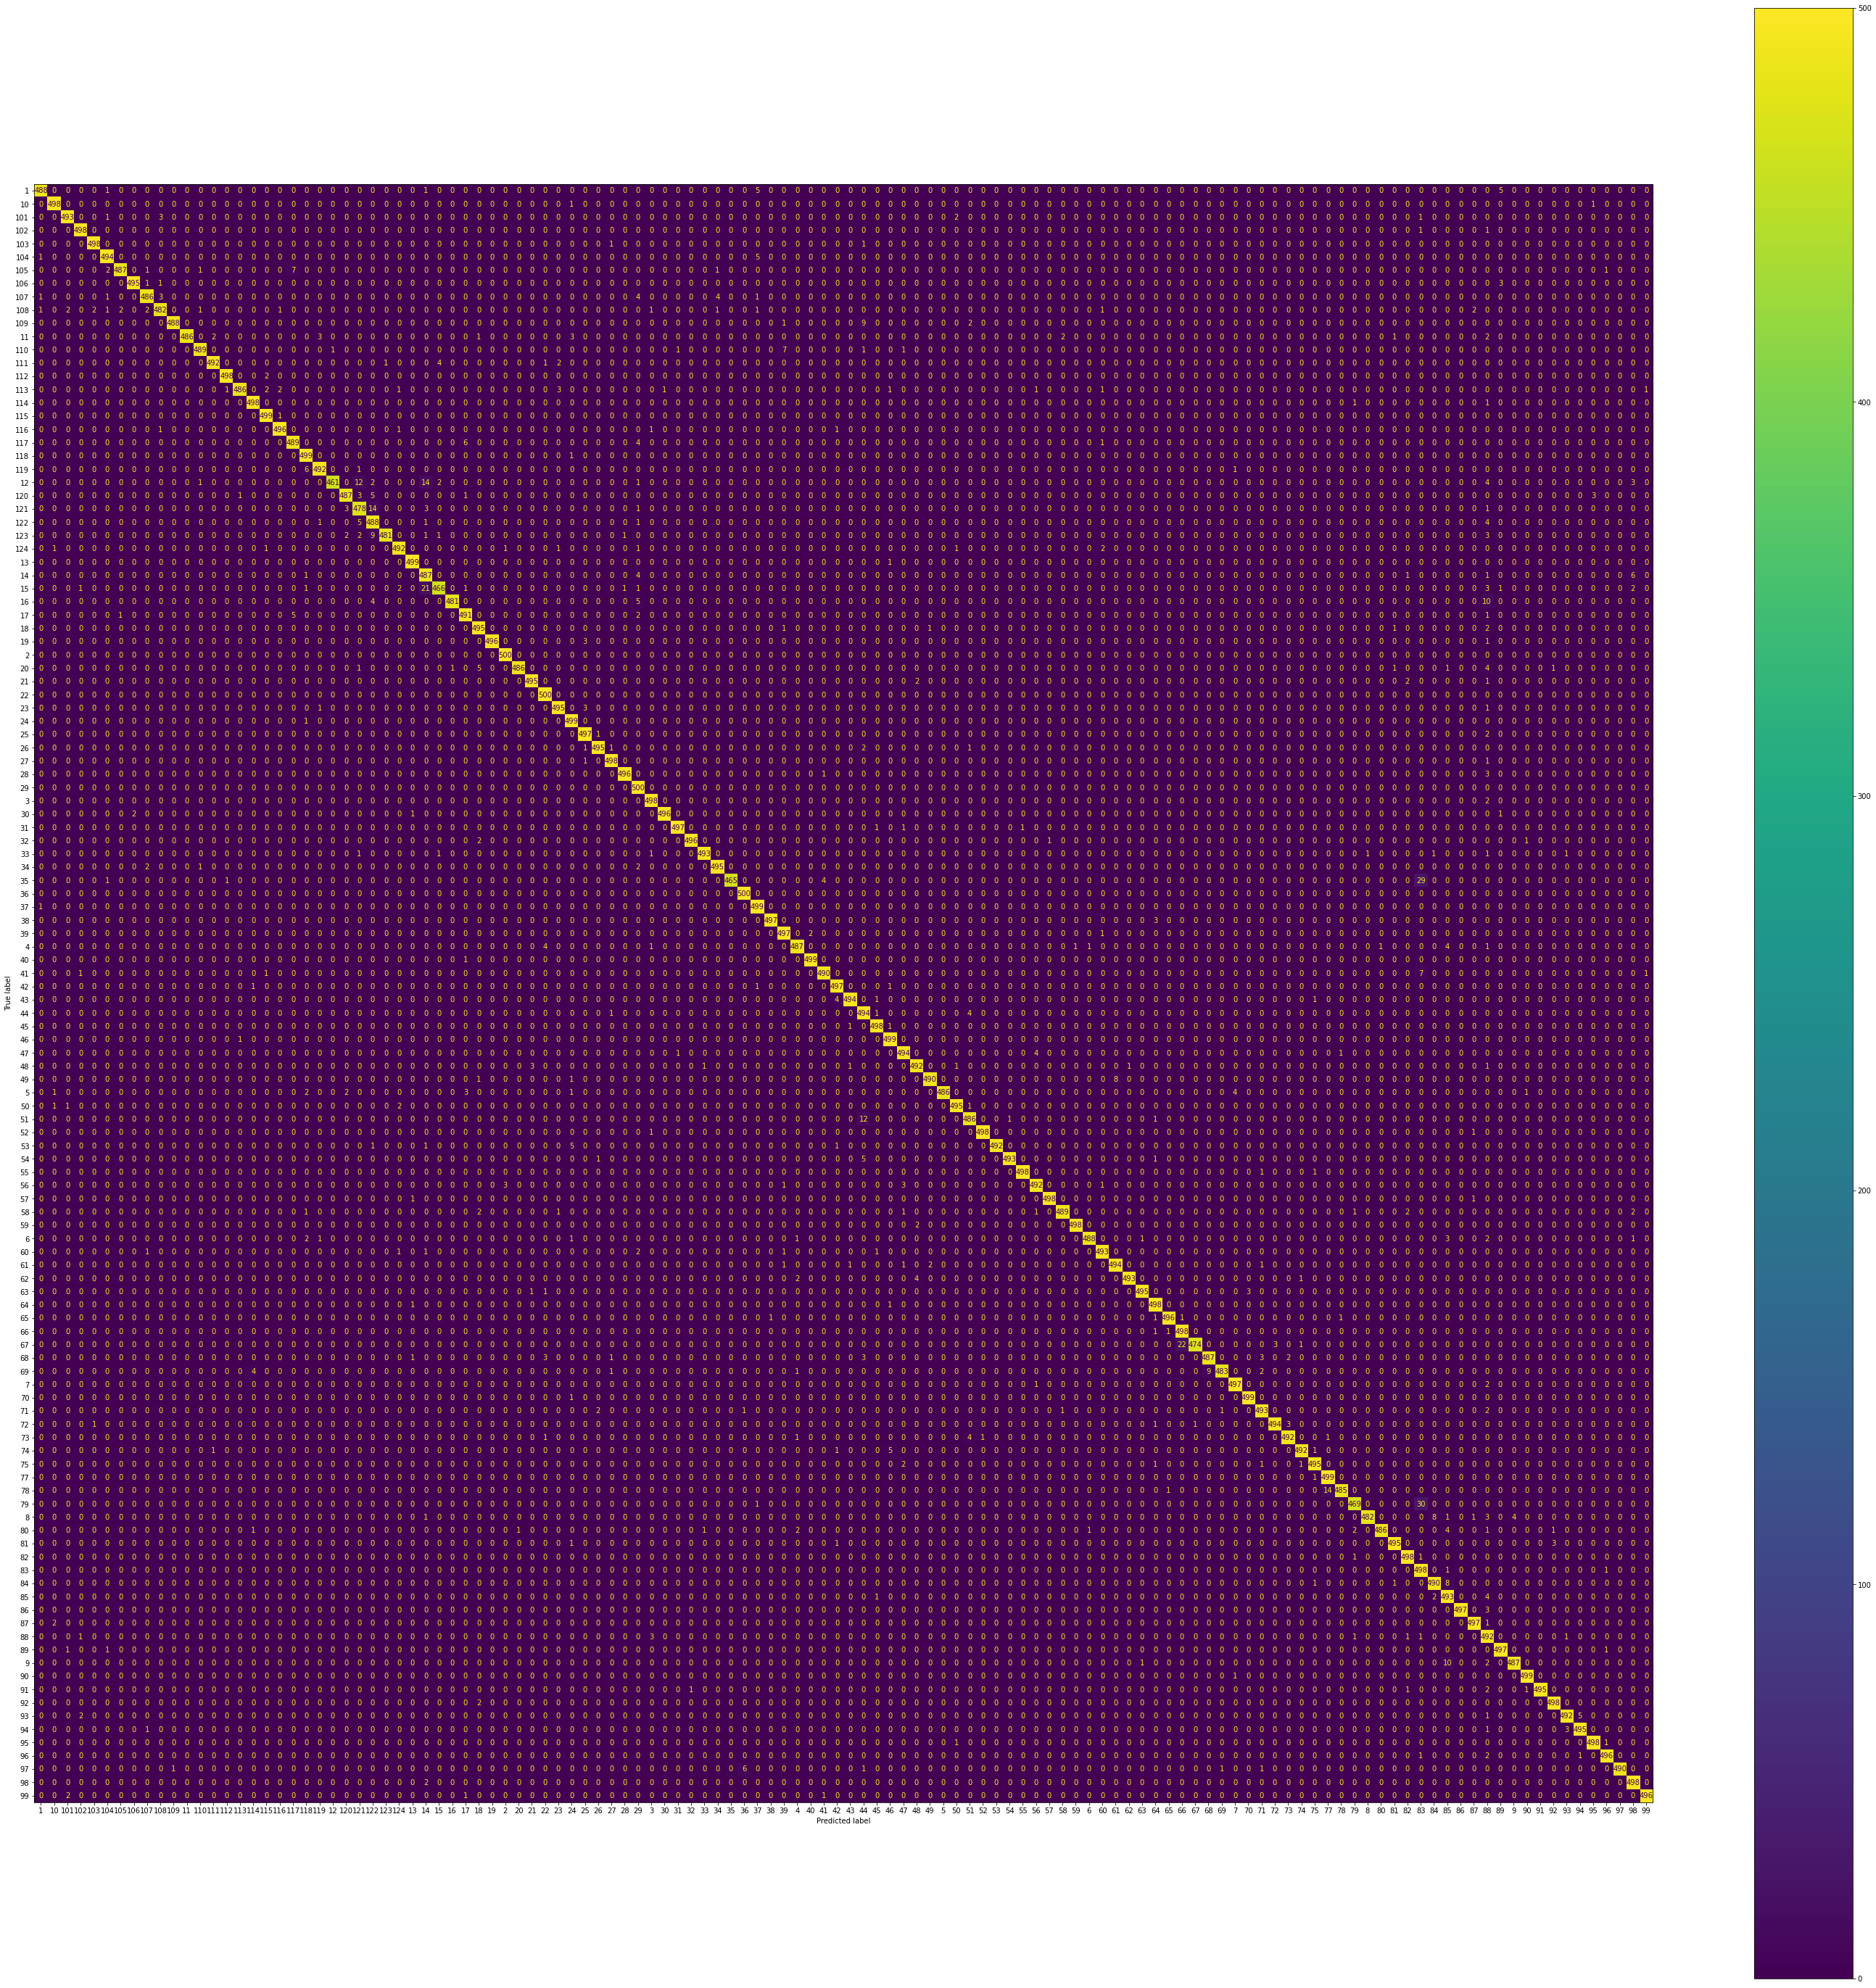

In [ ]:
con_mat = confusion_matrix(y_true,y_index)
fig, ax = plt.subplots(figsize=(50, 50))
ConfusionMatrixDisplay(con_mat,class_names).plot(ax=ax,values_format = 'd')